In [1]:
# import basic packages
from functools import reduce
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import sklearn tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from scipy import stats
%matplotlib inline

# define min_max scaler 
mms = MinMaxScaler()

In [2]:
# read training csv
training_data = pd.read_csv("Data/train.csv")

# define middle data
columns = ["cholestoral", "high_sugar", "ecg", "max_rate", "exercise_angina", "st_depression", "heart_disease"]
middle_six = training_data[columns].copy()
middle_six

cholestoral  high_sugar  ecg  max_rate  exercise_angina  st_depression  \
0            233           1    2       150                0            2.3   
1            286           0    2       108                1            1.5   
2            229           0    2       129                1            2.6   
3            204           0    2       172                0            1.4   
4            236           0    0       178                0            0.8   
..           ...         ...  ...       ...              ...            ...   
223          157           0    0       182                0            0.0   
224          176           1    2        90                0            1.0   
225          241           0    0       123                1            0.2   
226          131           0    0       115                1            1.2   
227          175           0    0       173                0            0.0   

     heart_disease  
0                0  
1                1  
2                1  
3                0  
4                0  
..             ...  
223              0  
224              1  
225              1  
226              1  
227              0  

[228 rows x 7 columns]

In [3]:
# briefly describe data
middle_six.describe()

cholestoral  high_sugar         ecg    max_rate  exercise_angina  \
count   228.000000  228.000000  228.000000  228.000000       228.000000   
mean    248.337719    0.140351    1.026316  148.675439         0.324561   
std      49.388909    0.348115    0.993020   23.969693         0.469241   
min     126.000000    0.000000    0.000000   71.000000         0.000000   
25%     212.750000    0.000000    0.000000  131.000000         0.000000   
50%     244.000000    0.000000    2.000000  152.000000         0.000000   
75%     276.250000    0.000000    2.000000  167.250000         1.000000   
max     417.000000    1.000000    2.000000  202.000000         1.000000   

       st_depression  heart_disease  
count     228.000000     228.000000  
mean        1.010526       0.473684  
std         1.146215       0.500406  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.800000       0.000000  
75%         1.600000       1.000000  
max         6.200000       1.000000

In [4]:
# print some overall info
print("shape:", middle_six.shape)
print("dtype:", middle_six.dtypes)
match_status = (middle_six.dtypes == "float64") | (middle_six.dtypes == "int64")
match_dtype = middle_six.dtypes[match_status]
print("matched index:", match_dtype.index)

shape: (228, 7)
dtype: cholestoral          int64
high_sugar           int64
ecg                  int64
max_rate             int64
exercise_angina      int64
st_depression      float64
heart_disease        int64
dtype: object
matched index: Index(['cholestoral', 'high_sugar', 'ecg', 'max_rate', 'exercise_angina',
       'st_depression', 'heart_disease'],
      dtype='object')


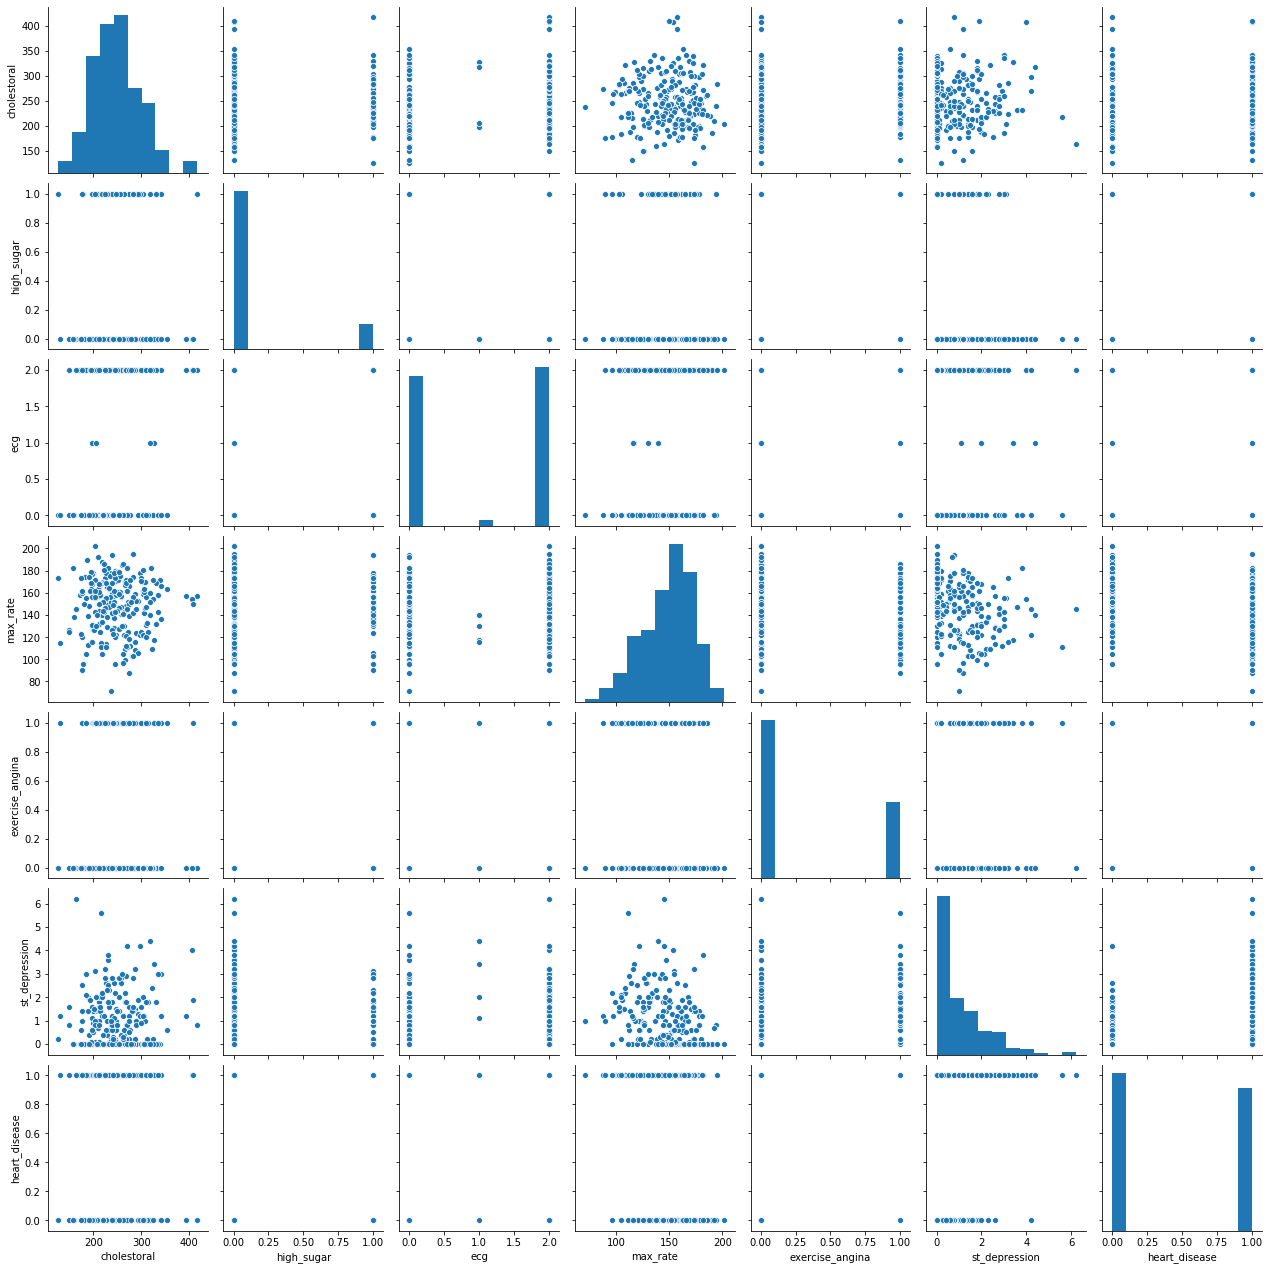

In [5]:
# print all variables' pariplot
sns.pairplot(middle_six.loc[:,match_status])

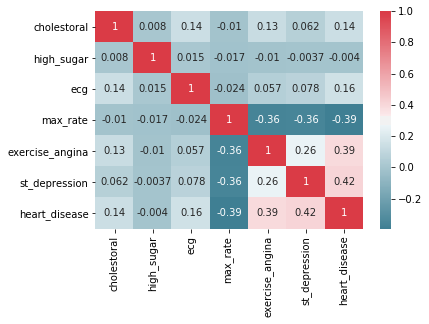

In [6]:
# print correlation and use seaborn to plot heatmap
middle_six_corr = middle_six.loc[:,match_status].corr()
sns.heatmap(middle_six_corr, xticklabels=middle_six_corr.columns, yticklabels=middle_six_corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

In [7]:
# cholestoral column, and get unique value
cholestoral = middle_six.iloc[:,0]
print(cholestoral, "\n")
print('陣列中的總和--------------->',cholestoral.sum())
print('陣列中的平均值------------->',cholestoral.mean())
print('陣列中最小值--------------->',cholestoral.min())
print('陣列中第一四分位--------------->',cholestoral.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',cholestoral.median())
print('陣列中第三四分位--------------->',cholestoral.quantile([0.75]).values[0])
print('陣列中最大值--------------->',cholestoral.max())
print('陣列中的個數--------------->',cholestoral.count())
print('nan 個數: {}, 值為: {}'.format(len(cholestoral[cholestoral.isna()]), cholestoral[cholestoral.isna()]))
print('unique value: {}'.format(cholestoral.unique()))

0      233
1      286
2      229
3      204
4      236
      ... 
223    157
224    176
225    241
226    131
227    175
Name: cholestoral, Length: 228, dtype: int64 

陣列中的總和---------------> 56621
陣列中的平均值-------------> 248.33771929824562
陣列中最小值---------------> 126
陣列中第一四分位---------------> 212.75
陣列中middle two的平均值---> 244.0
陣列中第三四分位---------------> 276.25
陣列中最大值---------------> 417
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: cholestoral, dtype: int64)
unique value: [233 286 229 204 236 354 254 203 192 294 199 239 275 266 211 224 340 226
 247 335 177 276 243 212 330 230 175 417 198 290 219 253 172 273 213 305
 304 188 282 185 232 231 269 267 248 197 258 245 270 264 321 274 325 257
 216 164 252 255 201 222 260 182 303 265 309 307 186 341 263 407 217 234
 220 209 227 261 250 281 288 240 289 308 318 298 246 322 299 300 214 223
 160 249 394 184 409 244 195 283 196 126 313 259 200 228 193 271 268 210
 277 327 149 306 178 237 208 218 242 319 315 180 311 278 205 225 342 157
 176 

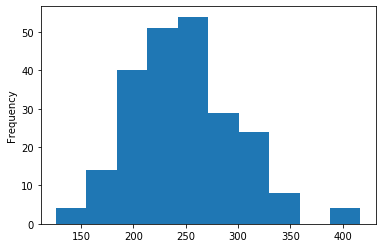

In [8]:
cholestoral.plot.hist()

In [9]:
# 根據上面 histogram，試著找到最佳分群來當作 bin 區間
Sum_of_squared_distances = []
Sum_of_squared_thre = 0.3
current_k = 0
current_dst = 0
center = None
cholestoral_val = cholestoral.values
cholestoral_val = cholestoral_val.reshape(-1,1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cholestoral_val)
    if k == 1 :
        current_dst = km.inertia_
        current_k = k
        center = km.cluster_centers_
    else :
        if np.abs(current_dst - km.inertia_)/current_dst >= Sum_of_squared_thre :
            current_k = k
            center = km.cluster_centers_
        current_dst = km.inertia_
    Sum_of_squared_distances.append(current_dst)

final_center = []
center = center.astype(np.float64)
center = center.reshape(-1)
center = np.sort(center)
center = center.tolist()
final_center.append(cholestoral_val.min())
final_center.extend(center)
final_center.append(cholestoral_val.max())
current_k, final_center, len(final_center)

(6,
 [126,
  169.8181818181818,
  207.7254901960784,
  239.56250000000003,
  271.95833333333337,
  314.82051282051276,
  406.75,
  417],
 8)

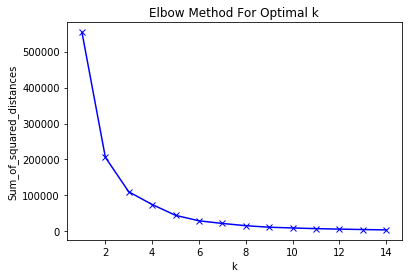

In [10]:
# plot k means result
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
# cut bins by k means result
bins = final_center
label_name = [str(i) for i in list(range(len(bins)-1))]
middle_six["cholestoral_label"] = pd.cut(middle_six.cholestoral, bins, labels=label_name, include_lowest=True)
middle_six

cholestoral  high_sugar  ecg  max_rate  exercise_angina  st_depression  \
0            233           1    2       150                0            2.3   
1            286           0    2       108                1            1.5   
2            229           0    2       129                1            2.6   
3            204           0    2       172                0            1.4   
4            236           0    0       178                0            0.8   
..           ...         ...  ...       ...              ...            ...   
223          157           0    0       182                0            0.0   
224          176           1    2        90                0            1.0   
225          241           0    0       123                1            0.2   
226          131           0    0       115                1            1.2   
227          175           0    0       173                0            0.0   

     heart_disease cholestoral_label  
0                0                 2  
1                1                 4  
2                1                 2  
3                0                 1  
4                0                 2  
..             ...               ...  
223              0                 0  
224              1                 1  
225              1                 3  
226              1                 0  
227              0                 1  

[228 rows x 8 columns]

In [12]:
cholestoral_label = middle_six["cholestoral_label"]
print('nan 個數: {}, 值為: {}'.format(len(cholestoral_label[cholestoral_label.isna()]), cholestoral_label[cholestoral_label.isna()]))
print('unique value: {}'.format(cholestoral_label.unique()))

nan 個數: 0, 值為: Series([], Name: cholestoral_label, dtype: category
Categories (7, object): [0 < 1 < 2 < 3 < 4 < 5 < 6])
unique value: [2, 4, 1, 5, 3, 6, 0]
Categories (7, object): [0 < 1 < 2 < 3 < 4 < 5 < 6]


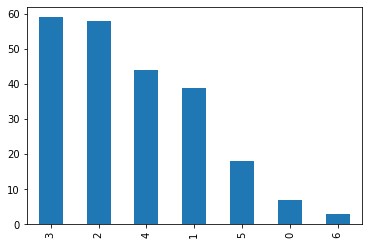

In [13]:
# plot bins from result
cholestoral_label = middle_six["cholestoral_label"].value_counts()
cholestoral_label.plot(kind='bar')

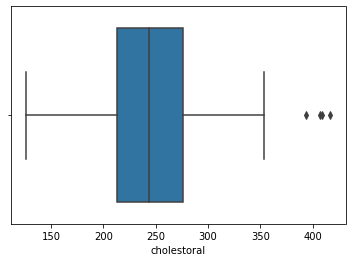

In [14]:
# find outliers and boxplot
sns.boxplot(x=cholestoral)

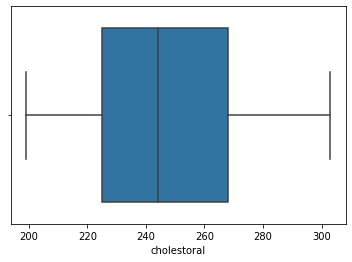

In [15]:
without_outlier = cholestoral.between(cholestoral.quantile(.15), cholestoral.quantile(.85))
outlier = ~without_outlier
cholestoral_without_outlier = cholestoral[without_outlier] # without outliers
sns.boxplot(x=cholestoral_without_outlier)

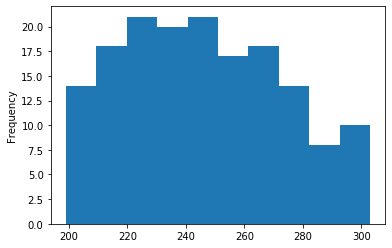

In [16]:
cholestoral_without_outlier.plot.hist()

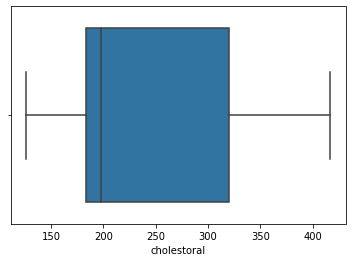

In [17]:
cholestoral_with_outlier = cholestoral[outlier] # without outliers
sns.boxplot(x=cholestoral_with_outlier)

In [18]:
# high_sugar column
high_sugar = middle_six.iloc[:,1]
print(high_sugar, "\n")
print('陣列中的總和--------------->',high_sugar.sum())
print('陣列中的平均值------------->',high_sugar.mean())
print('陣列中最小值--------------->',high_sugar.min())
print('陣列中第一四分位--------------->',high_sugar.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',high_sugar.median())
print('陣列中第三四分位--------------->',high_sugar.quantile([0.75]).values[0])
print('陣列中最大值--------------->',high_sugar.max())
print('陣列中的個數--------------->',high_sugar.count())
print('nan 個數: {}, 值為: {}'.format(len(high_sugar[high_sugar.isna()]), high_sugar[high_sugar.isna()]))
print('unique value: {}'.format(high_sugar.unique()))
high_sugar

0      1
1      0
2      0
3      0
4      0
      ..
223    0
224    1
225    0
226    0
227    0
Name: high_sugar, Length: 228, dtype: int64 

陣列中的總和---------------> 32
陣列中的平均值-------------> 0.14035087719298245
陣列中最小值---------------> 0
陣列中第一四分位---------------> 0.0
陣列中middle two的平均值---> 0.0
陣列中第三四分位---------------> 0.0
陣列中最大值---------------> 1
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: high_sugar, dtype: int64)
unique value: [1 0]


0      1
1      0
2      0
3      0
4      0
      ..
223    0
224    1
225    0
226    0
227    0
Name: high_sugar, Length: 228, dtype: int64

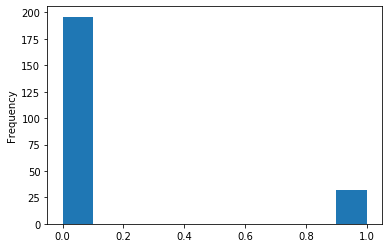

In [19]:
# plot high sugar
high_sugar.plot.hist()

In [20]:
# contigency table between answer
crosstab_high_sugar = pd.crosstab(middle_six.high_sugar, middle_six.heart_disease)
crosstab_high_sugar

heart_disease    0   1
high_sugar            
0              103  93
1               17  15

In [21]:
# get mutal information and chi square's p value
mi_score = mutual_info_score(middle_six.high_sugar.values, middle_six.heart_disease.values, crosstab_high_sugar.values)
chi2_stat, p, dof, ex = stats.chi2_contingency(crosstab_high_sugar.values)

# select significance value
alpha = 0.05

print("===Chi Square Test===\n")
print("===Chi2 Stat===")
print(chi2_stat)
print("\n===Degrees of Freedom===")
print(dof)
print("\n===P-Value===")
print(p)
print("\n===Contingency Table===")
print(ex)

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('\nVariables are associated (reject H0)')
else:
    print('\nVariables are not associated(fail to reject H0)')

print("\n===Mutual Information's score=== \n{}".format(mi_score))


===Chi Square Test===

===Chi2 Stat===
0.017065263605442114

===Degrees of Freedom===
1

===P-Value===
0.8960647795279932

===Contingency Table===
[[103.15789474  92.84210526]
 [ 16.84210526  15.15789474]]
significance=0.050, p=0.896

Variables are not associated(fail to reject H0)

===Mutual Information's score=== 
7.974368301910673e-06


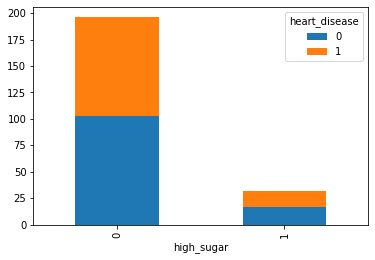

In [22]:
# plot bar chart base on Contingency
crosstab_high_sugar.plot.bar(stacked=True)

In [23]:
# 分組的方式印出列中表
high_sugar_groupby = middle_six.groupby(["high_sugar", "heart_disease"]).mean()
# high_sugar_groupby = pd.pivot_table(middle_six, index=["high_sugar", "heart_disease"])
high_sugar_groupby

cholestoral       ecg    max_rate  exercise_angina  \
high_sugar heart_disease                                                       
0          0               241.980583  0.902913  157.747573         0.165049   
           1               255.043011  1.150538  138.967742         0.505376   
1          0               239.117647  0.705882  156.470588         0.058824   
           1               260.866667  1.466667  137.733333         0.600000   

                          st_depression  
high_sugar heart_disease                 
0          0                   0.566990  
           1                   1.505376  
1          0                   0.500000  
           1                   1.566667

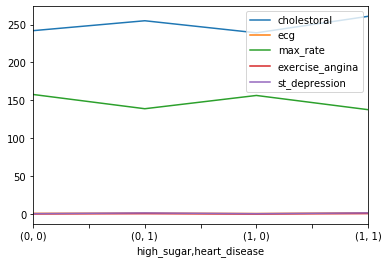

In [24]:
# 畫出折線圖
high_sugar_groupby.plot.line()

In [25]:
# ecg column
ecg = middle_six.iloc[:,2]
print(ecg, "\n")
print('陣列中的總和--------------->',ecg.sum())
print('陣列中的平均值------------->',ecg.mean())
print('陣列中最小值--------------->',ecg.min())
print('陣列中第一四分位--------------->',ecg.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',ecg.median())
print('陣列中第三四分位--------------->',ecg.quantile([0.75]).values[0])
print('陣列中最大值--------------->',ecg.max())
print('陣列中的個數--------------->',ecg.count())
print('nan 個數: {}, 值為: {}'.format(len(ecg[ecg.isna()]), ecg[ecg.isna()]))
print('unique value: {}'.format(ecg.unique()))
ecg

0      2
1      2
2      2
3      2
4      0
      ..
223    0
224    2
225    0
226    0
227    0
Name: ecg, Length: 228, dtype: int64 

陣列中的總和---------------> 234
陣列中的平均值-------------> 1.0263157894736843
陣列中最小值---------------> 0
陣列中第一四分位---------------> 0.0
陣列中middle two的平均值---> 2.0
陣列中第三四分位---------------> 2.0
陣列中最大值---------------> 2
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: ecg, dtype: int64)
unique value: [2 0 1]


0      2
1      2
2      2
3      2
4      0
      ..
223    0
224    2
225    0
226    0
227    0
Name: ecg, Length: 228, dtype: int64

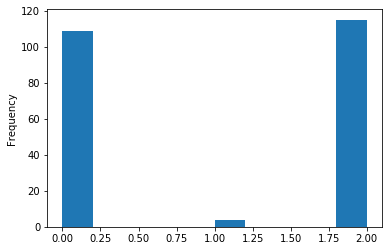

In [26]:
# plot basic histogram
ecg.plot.hist()

In [27]:
# contigency table
crosstab_ecg = pd.crosstab(middle_six.ecg, middle_six.heart_disease)
crosstab_ecg

heart_disease   0   1
ecg                  
0              67  42
1               1   3
2              52  63

In [28]:
# get mutal information and chi square's p value
mi_score = mutual_info_score(middle_six.ecg.values, middle_six.heart_disease.values, crosstab_ecg.values)
chi2_stat, p, dof, ex = stats.chi2_contingency(crosstab_ecg.values)

# select significance value
alpha = 0.05

print("===Chi Square Test===\n")
print("===Chi2 Stat===")
print(chi2_stat)
print("\n===Degrees of Freedom===")
print(dof)
print("\n===P-Value===")
print(p)
print("\n===Contingency Table===")
print(ex)

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('\nVariables are associated (reject H0)')
else:
    print('\nVariables are not associated(fail to reject H0)')

print("\n===Mutual Information's score=== \n{}".format(mi_score))

===Chi Square Test===

===Chi2 Stat===
7.17441364180295

===Degrees of Freedom===
2

===P-Value===
0.02767552526225857

===Contingency Table===
[[57.36842105 51.63157895]
 [ 2.10526316  1.89473684]
 [60.52631579 54.47368421]]
significance=0.050, p=0.028

Variables are associated (reject H0)

===Mutual Information's score=== 
0.015907271189134244


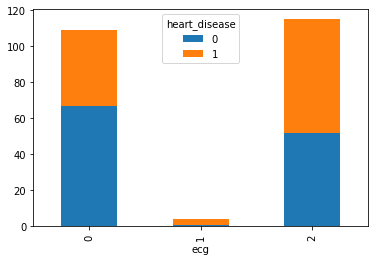

In [29]:
# plot bar chart base on conabstigency table
crosstab_ecg.plot.bar(stacked=True)

In [30]:
# 分組的方式印出列中表
ecg_groupby = middle_six.groupby(["ecg", "heart_disease"]).mean()
# ecg_groupby = pd.pivot_table(middle_six, index=["ecg", "heart_disease"])
ecg_groupby

cholestoral  high_sugar    max_rate  exercise_angina  \
ecg heart_disease                                                         
0   0               237.164179    0.164179  157.522388         0.119403   
    1               246.428571    0.095238  137.214286         0.571429   
1   0               197.000000    0.000000  116.000000         0.000000   
    1               283.333333    0.000000  129.000000         0.666667   
2   0               248.115385    0.115385  158.423077         0.192308   
    1               260.825397    0.174603  140.317460         0.476190   

                   st_depression  
ecg heart_disease                 
0   0                   0.516418  
    1                   1.476190  
1   0                   1.100000  
    1                   3.266667  
2   0                   0.600000  
    1                   1.455556

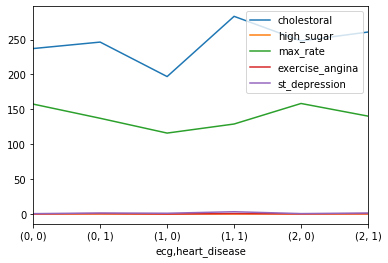

In [31]:
# 畫出折線圖
ecg_groupby.plot.line()

In [32]:
# high_sugar column
max_rate = middle_six.iloc[:,3]
print(high_sugar, "\n")
print('陣列中的總和--------------->',max_rate.sum())
print('陣列中的平均值------------->',max_rate.mean())
print('陣列中最小值--------------->',max_rate.min())
print('陣列中第一四分位--------------->',max_rate.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',max_rate.median())
print('陣列中第三四分位--------------->',max_rate.quantile([0.75]).values[0])
print('陣列中最大值--------------->',max_rate.max())
print('陣列中的個數--------------->',max_rate.count())
print('nan 個數: {}, 值為: {}'.format(len(max_rate[max_rate.isna()]), max_rate[max_rate.isna()]))
print('unique value: {}'.format(max_rate.unique()))

0      1
1      0
2      0
3      0
4      0
      ..
223    0
224    1
225    0
226    0
227    0
Name: high_sugar, Length: 228, dtype: int64 

陣列中的總和---------------> 33898
陣列中的平均值-------------> 148.67543859649123
陣列中最小值---------------> 71
陣列中第一四分位---------------> 131.0
陣列中middle two的平均值---> 152.0
陣列中第三四分位---------------> 167.25
陣列中最大值---------------> 202
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: max_rate, dtype: int64)
unique value: [150 108 129 172 178 163 147 155 148 153 162 168 160 139 171 144 173 114
 151 158 120 112 137 157 169 165 123 128 188 109 152 125 142 170 113  99
 177 141 180 111 143 182 156 115 145 146 161 186 185 174 159 130 140 190
 136  97 132 127 154 175 126 202 103 131 124 179 122  96 138  88 105 166
 194 195 106 133 167 192 117 121 116  71 118 181 149 134 164  90]


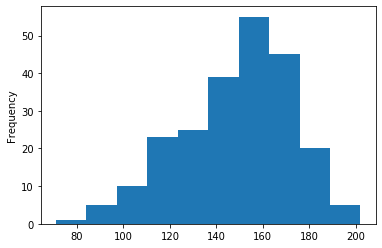

In [33]:
# plot basic histogram
max_rate.plot.hist()

In [34]:
# 根據上面 histogram，試著找到最佳分群來當作 bin 區間
Sum_of_squared_distances = []
Sum_of_squared_thre = 0.3
current_k = 0
current_dst = 0
center = None
max_rate_val = max_rate.values
max_rate_val = max_rate_val.reshape(-1,1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(max_rate_val)
    if k == 1 :
        current_dst = km.inertia_
        current_k = k
        center = km.cluster_centers_
    else :
        if np.abs(current_dst - km.inertia_)/current_dst >= Sum_of_squared_thre :
            current_k = k
            center = km.cluster_centers_
        current_dst = km.inertia_
    Sum_of_squared_distances.append(current_dst)

final_center = []
center = center.astype(np.float64)
center = center.reshape(-1)
center = np.sort(center)
center = center.tolist()
final_center.append(max_rate_val.min())
final_center.extend(center)
final_center.append(max_rate_val.max())
current_k, final_center, len(final_center)

(5,
 [71,
  103.21739130434786,
  124.85000000000002,
  145.57142857142858,
  161.1935483870968,
  178.38297872340428,
  202],
 7)

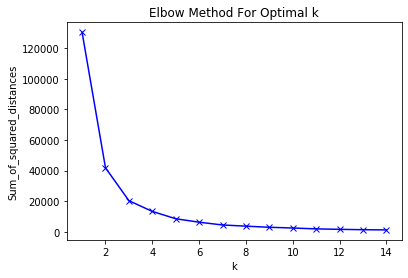

In [35]:
# plot k means result
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [36]:
# cut bins by k means result
bins = final_center
label_name = [str(i) for i in list(range(len(bins)-1))]
middle_six["max_rate_label"] = pd.cut(middle_six.max_rate, bins, labels=label_name, include_lowest=True)
middle_six

cholestoral  high_sugar  ecg  max_rate  exercise_angina  st_depression  \
0            233           1    2       150                0            2.3   
1            286           0    2       108                1            1.5   
2            229           0    2       129                1            2.6   
3            204           0    2       172                0            1.4   
4            236           0    0       178                0            0.8   
..           ...         ...  ...       ...              ...            ...   
223          157           0    0       182                0            0.0   
224          176           1    2        90                0            1.0   
225          241           0    0       123                1            0.2   
226          131           0    0       115                1            1.2   
227          175           0    0       173                0            0.0   

     heart_disease cholestoral_label max_rate_label  
0                0                 2              3  
1                1                 4              1  
2                1                 2              2  
3                0                 1              4  
4                0                 2              4  
..             ...               ...            ...  
223              0                 0              5  
224              1                 1              0  
225              1                 3              1  
226              1                 0              1  
227              0                 1              4  

[228 rows x 9 columns]

In [37]:
max_rate_label = middle_six["max_rate_label"]
print('nan 個數: {}, 值為: {}'.format(len(max_rate_label[max_rate_label.isna()]), max_rate_label[max_rate_label.isna()]))
print('unique value: {}'.format(max_rate_label.unique()))

nan 個數: 0, 值為: Series([], Name: max_rate_label, dtype: category
Categories (6, object): [0 < 1 < 2 < 3 < 4 < 5])
unique value: [3, 1, 2, 4, 5, 0]
Categories (6, object): [0 < 1 < 2 < 3 < 4 < 5]


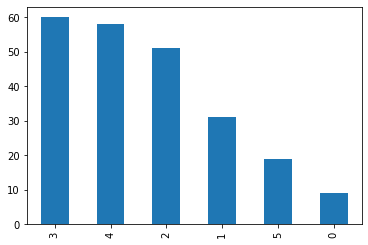

In [38]:
# plot bins from result
max_rate_label = middle_six["max_rate_label"].value_counts()
max_rate_label.plot(kind='bar')

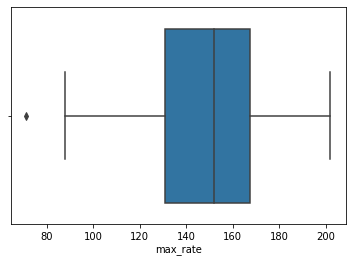

In [39]:
# find outliers and boxplot
sns.boxplot(x=max_rate)

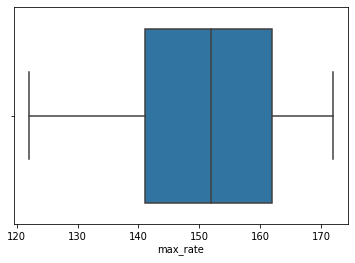

In [40]:
without_outlier = max_rate.between(max_rate.quantile(.15), max_rate.quantile(.85))
outlier = ~without_outlier
max_rate_without_outlier = max_rate[without_outlier] # without outliers
sns.boxplot(x=max_rate_without_outlier)

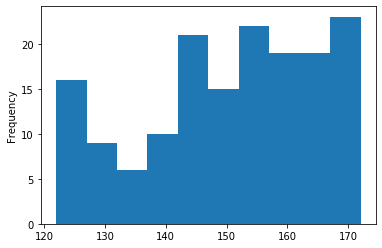

In [41]:
max_rate_without_outlier.plot.hist()

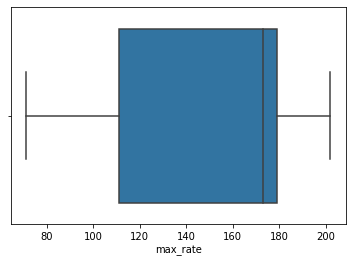

In [42]:
max_rate_with_outlier = max_rate[outlier] # without outliers
sns.boxplot(x=max_rate_with_outlier)

In [43]:
# exercise_angina column
exercise_angina = middle_six.iloc[:,4]
print(exercise_angina, "\n")
print('陣列中的總和--------------->',exercise_angina.sum())
print('陣列中的平均值------------->',exercise_angina.mean())
print('陣列中最小值--------------->',exercise_angina.min())
print('陣列中第一四分位--------------->',exercise_angina.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',exercise_angina.median())
print('陣列中第三四分位--------------->',exercise_angina.quantile([0.75]).values[0])
print('陣列中最大值--------------->',exercise_angina.max())
print('陣列中的個數--------------->',exercise_angina.count())
print('nan 個數: {}, 值為: {}'.format(len(exercise_angina[exercise_angina.isna()]), exercise_angina[exercise_angina.isna()]))
print('unique value: {}'.format(exercise_angina.unique()))
exercise_angina

0      0
1      1
2      1
3      0
4      0
      ..
223    0
224    0
225    1
226    1
227    0
Name: exercise_angina, Length: 228, dtype: int64 

陣列中的總和---------------> 74
陣列中的平均值-------------> 0.32456140350877194
陣列中最小值---------------> 0
陣列中第一四分位---------------> 0.0
陣列中middle two的平均值---> 0.0
陣列中第三四分位---------------> 1.0
陣列中最大值---------------> 1
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: exercise_angina, dtype: int64)
unique value: [0 1]


0      0
1      1
2      1
3      0
4      0
      ..
223    0
224    0
225    1
226    1
227    0
Name: exercise_angina, Length: 228, dtype: int64

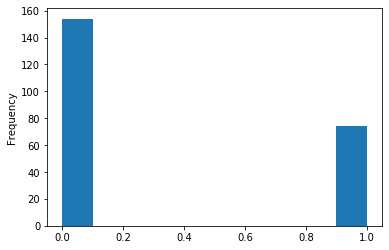

In [44]:
# plot basic histogram
exercise_angina.plot.hist()

In [45]:
crosstab_exercise_angina = pd.crosstab(middle_six.exercise_angina, middle_six.heart_disease)
crosstab_exercise_angina

heart_disease      0   1
exercise_angina         
0                102  52
1                 18  56

In [46]:
# get mutal information and chi square's p value
mi_score = mutual_info_score(middle_six.exercise_angina.values, middle_six.heart_disease.values, crosstab_exercise_angina.values)
chi2_stat, p, dof, ex = stats.chi2_contingency(crosstab_exercise_angina.values)

# select significance value
alpha = 0.05

print("===Chi Square Test===\n")
print("===Chi2 Stat===")
print(chi2_stat)
print("\n===Degrees of Freedom===")
print(dof)
print("\n===P-Value===")
print(p)
print("\n===Contingency Table===")
print(ex)

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('\nVariables are associated (reject H0)')
else:
    print('\nVariables are not associated(fail to reject H0)')

print("\n===Mutual Information's score=== \n{}".format(mi_score))


===Chi Square Test===

===Chi2 Stat===
33.55227272727272

===Degrees of Freedom===
1

===P-Value===
6.937426621743426e-09

===Contingency Table===
[[81.05263158 72.94736842]
 [38.94736842 35.05263158]]
significance=0.050, p=0.000

Variables are associated (reject H0)

===Mutual Information's score=== 
0.07977364348277668


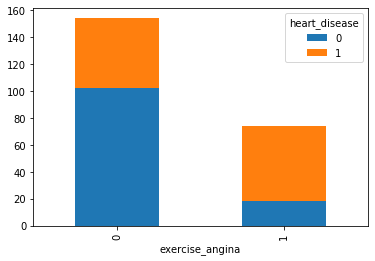

In [47]:
# plot bar chart based on contigency table
crosstab_exercise_angina.plot.bar(stacked=True)

In [48]:
exercise_angina_groupby = middle_six.groupby(["exercise_angina", "heart_disease"]).mean()
# exercise_angina_groupby = pd.pivot_table(middle_six, index=["exercise_angina", "heart_disease"])
exercise_angina_groupby

cholestoral  high_sugar       ecg    max_rate  \
exercise_angina heart_disease                                                  
0               0               241.284314    0.156863  0.833333  159.519608   
                1               248.711538    0.115385  1.288462  145.153846   
1               0               243.222222    0.055556  1.111111  146.500000   
                1               262.482143    0.160714  1.107143  132.892857   

                               st_depression  
exercise_angina heart_disease                 
0               0                   0.543137  
                1                   1.313462  
1               0                   0.638889  
                1                   1.700000

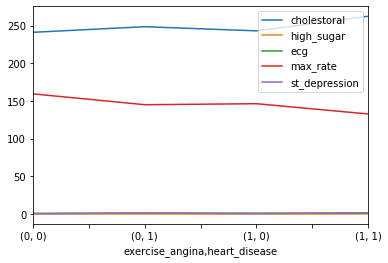

In [49]:
# 畫出折線圖
exercise_angina_groupby.plot.line()

In [50]:
# st_depression column
st_depression = middle_six.iloc[:,5]
print(st_depression, "\n")
print('陣列中的總和--------------->',st_depression.sum())
print('陣列中的平均值------------->',st_depression.mean())
print('陣列中最小值--------------->',st_depression.min())
print('陣列中第一四分位--------------->',st_depression.quantile([0.25]).values[0])
print('陣列中middle two的平均值--->',st_depression.median())
print('陣列中第三四分位--------------->',st_depression.quantile([0.75]).values[0])
print('陣列中最大值--------------->',st_depression.max())
print('陣列中的個數--------------->',st_depression.count())
print('nan 個數: {}, 值為: {}'.format(len(st_depression[st_depression.isna()]), st_depression[st_depression.isna()]))
print('unique value: {}'.format(st_depression.unique()))
st_depression

0      2.3
1      1.5
2      2.6
3      1.4
4      0.8
      ... 
223    0.0
224    1.0
225    0.2
226    1.2
227    0.0
Name: st_depression, Length: 228, dtype: float64 

陣列中的總和---------------> 230.4
陣列中的平均值-------------> 1.0105263157894737
陣列中最小值---------------> 0.0
陣列中第一四分位---------------> 0.0
陣列中middle two的平均值---> 0.8
陣列中第三四分位---------------> 1.6
陣列中最大值---------------> 6.2
陣列中的個數---------------> 228
nan 個數: 0, 值為: Series([], Name: st_depression, dtype: float64)
unique value: [2.3 1.5 2.6 1.4 0.8 0.6 3.1 0.4 1.3 0.5 1.  1.2 0.2 1.8 3.2 0.  2.5 1.6
 2.2 2.8 3.  3.6 6.2 2.  4.  5.6 2.4 2.9 0.1 2.1 1.9 4.2 0.9 1.1 3.8 0.7
 3.4 0.3 4.4]


0      2.3
1      1.5
2      2.6
3      1.4
4      0.8
      ... 
223    0.0
224    1.0
225    0.2
226    1.2
227    0.0
Name: st_depression, Length: 228, dtype: float64

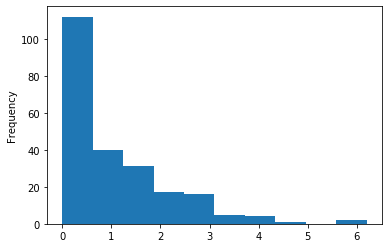

In [51]:
# plot basic histogram
st_depression.plot.hist()

In [52]:
# 根據上面 histogram，試著找到最佳分群來當作 bin 區間
Sum_of_squared_distances = []
Sum_of_squared_thre = 0.3
current_k = 0
current_dst = 0
center = None
st_depression_val = st_depression.values
st_depression_val = st_depression_val.reshape(-1,1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(st_depression_val)
    if k == 1 :
        current_dst = km.inertia_
        current_k = k
        center = km.cluster_centers_
    else :
        if np.abs(current_dst - km.inertia_)/current_dst >= Sum_of_squared_thre :
            current_k = k
            center = km.cluster_centers_
        current_dst = km.inertia_
    Sum_of_squared_distances.append(current_dst)

final_center = []
center = center.astype(np.float64)
center = center.reshape(-1)
center = np.sort(center)
center = center.tolist()
final_center.append(st_depression_val.min())
final_center.extend(center)
final_center.append(st_depression_val.max())
current_k, final_center, len(final_center)

(7,
 [0.0,
  0.053061224489794556,
  0.7800000000000001,
  1.3666666666666667,
  1.984615384615385,
  2.86,
  4.033333333333333,
  5.9,
  6.2],
 9)

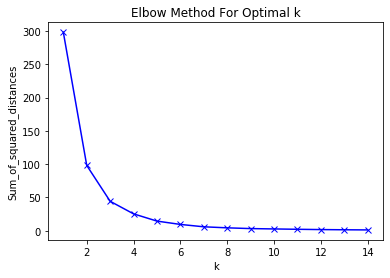

In [53]:
# plot k means result
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [54]:
# cut bins by k means result
bins = final_center
label_name = [str(i) for i in list(range(len(bins)-1))]
middle_six["st_depression_label"] = pd.cut(middle_six.st_depression, bins, labels=label_name, include_lowest=True)
middle_six

cholestoral  high_sugar  ecg  max_rate  exercise_angina  st_depression  \
0            233           1    2       150                0            2.3   
1            286           0    2       108                1            1.5   
2            229           0    2       129                1            2.6   
3            204           0    2       172                0            1.4   
4            236           0    0       178                0            0.8   
..           ...         ...  ...       ...              ...            ...   
223          157           0    0       182                0            0.0   
224          176           1    2        90                0            1.0   
225          241           0    0       123                1            0.2   
226          131           0    0       115                1            1.2   
227          175           0    0       173                0            0.0   

     heart_disease cholestoral_label max_rate_label st_depression_label  
0                0                 2              3                   4  
1                1                 4              1                   3  
2                1                 2              2                   4  
3                0                 1              4                   3  
4                0                 2              4                   2  
..             ...               ...            ...                 ...  
223              0                 0              5                   0  
224              1                 1              0                   2  
225              1                 3              1                   1  
226              1                 0              1                   2  
227              0                 1              4                   0  

[228 rows x 10 columns]

In [55]:
st_depression_label = middle_six["st_depression_label"]
print('nan 個數: {}, 值為: {}'.format(len(st_depression_label[st_depression_label.isna()]), st_depression_label[st_depression_label.isna()]))
print('unique value: {}'.format(st_depression_label.unique()))

nan 個數: 0, 值為: Series([], Name: st_depression_label, dtype: category
Categories (8, object): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7])
unique value: [4, 3, 2, 1, 5, 0, 7, 6]
Categories (8, object): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]


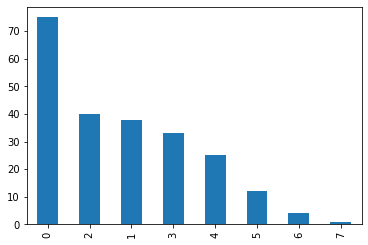

In [56]:
# plot bins from result
st_depression_label = middle_six["st_depression_label"].value_counts()
st_depression_label.plot(kind='bar')

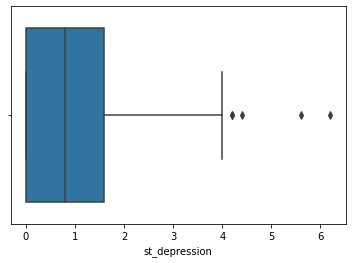

In [57]:
# find outliers and boxplot
sns.boxplot(x=st_depression)

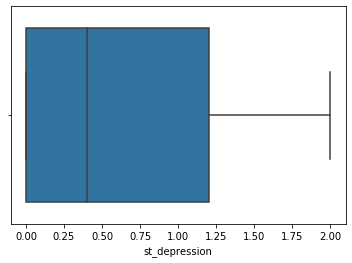

In [58]:
without_outlier = st_depression.between(st_depression.quantile(.15), st_depression.quantile(.85))
outlier = ~without_outlier
st_depression_without_outlier = st_depression[without_outlier] # without outliers
sns.boxplot(x=st_depression_without_outlier)

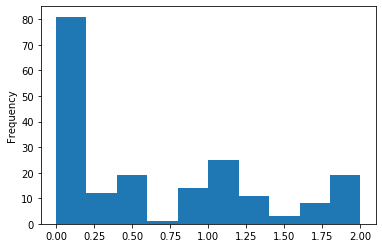

In [59]:
st_depression_without_outlier.plot.hist()

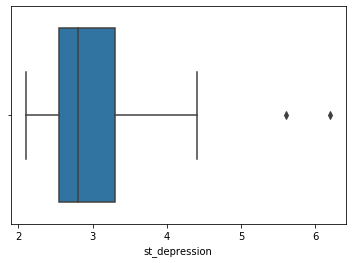

In [60]:
st_depression_with_outlier = st_depression[outlier] # without outliers
sns.boxplot(x=st_depression_with_outlier)

In [61]:
# gather all outlier and remove intersect index
cholestoral_outlier_index = cholestoral_with_outlier.index.values
max_rate_outlier_index = max_rate_with_outlier.index.values
st_depression_outlier_index = st_depression_with_outlier.index.values
cholestoral_outlier_index, max_rate_outlier_index, st_depression_outlier_index

(array([  5,   8,  17,  21,  23,  28,  30,  32,  33,  39,  42,  43,  44,
         45,  47,  53,  58,  60,  63,  72,  75,  76,  77,  80,  81,  82,
         85,  87, 101, 103, 108, 109, 114, 117, 118, 124, 128, 132, 135,
        138, 139, 144, 153, 154, 155, 157, 163, 174, 175, 176, 182, 183,
        193, 197, 199, 203, 205, 206, 212, 213, 216, 217, 222, 223, 224,
        226, 227]),
 array([  1,   4,  16,  18,  22,  23,  24,  26,  35,  37,  45,  51,  53,
         55,  56,  58,  62,  70,  71,  72,  81,  83,  89,  90,  91,  97,
         98, 100, 107, 110, 113, 114, 115, 121, 125, 126, 130, 132, 133,
        136, 139, 140, 141, 142, 147, 154, 160, 166, 170, 175, 177, 178,
        179, 183, 184, 186, 190, 191, 192, 193, 202, 205, 214, 216, 223,
        224, 226, 227]),
 array([  0,   2,   7,  16,  18,  23,  29,  31,  37,  46,  47,  49,  54,
         63,  68,  82,  86,  87,  89,  92, 113, 114, 125, 132, 137, 145,
        158, 160, 175, 178, 201, 204, 213, 217, 218]))

In [62]:
# deal with outher outlier
intersect_index = reduce(np.intersect1d, (cholestoral_outlier_index, max_rate_outlier_index, st_depression_outlier_index))
cholestoral_outlier_others = np.setdiff1d(cholestoral_outlier_index, intersect_index) # use mean to replace with it
max_rate_outlier_others = np.setdiff1d(max_rate_outlier_index, intersect_index) # use mean to replace with it
st_depression_outlier_others = np.setdiff1d(st_depression_outlier_index, intersect_index) # use median to replace with it

# get reset cholestoral, max_rate and st_depression
middle_six.iloc[cholestoral_outlier_others, columns.index("cholestoral")] = cholestoral_without_outlier.mean()
middle_six.iloc[max_rate_outlier_others, columns.index("max_rate")] = max_rate_without_outlier.mean()
middle_six.iloc[st_depression_outlier_others, columns.index("st_depression")] = st_depression_without_outlier.median()

In [64]:
middle_six = middle_six.drop(intersect_index)
middle_six_reset_index = middle_six.reset_index().index
middle_six.index = middle_six_reset_index
middle_six

cholestoral  high_sugar  ecg   max_rate  exercise_angina  st_depression  \
0      233.00000           1    2  150.00000                0            0.4   
1      286.00000           0    2  150.10625                1            1.5   
2      229.00000           0    2  129.00000                1            0.4   
3      204.00000           0    2  172.00000                0            1.4   
4      236.00000           0    0  150.10625                0            0.8   
..           ...         ...  ...        ...              ...            ...   
219    246.10559           0    0  150.10625                0            0.0   
220    246.10559           1    2  150.10625                0            1.0   
221    241.00000           0    0  123.00000                1            0.2   
222    246.10559           0    0  150.10625                1            1.2   
223    246.10559           0    0  150.10625                0            0.0   

     heart_disease cholestoral_label max_rate_label st_depression_label  
0                0                 2              3                   4  
1                1                 4              1                   3  
2                1                 2              2                   4  
3                0                 1              4                   3  
4                0                 2              4                   2  
..             ...               ...            ...                 ...  
219              0                 0              5                   0  
220              1                 1              0                   2  
221              1                 3              1                   1  
222              1                 0              1                   2  
223              0                 1              4                   0  

[224 rows x 10 columns]

In [69]:
# move column
moved_index = [1,5,8]
cholestoral_label = middle_six["cholestoral_label"]
max_rate_label = middle_six["max_rate_label"]
st_depression_label = middle_six["st_depression_label"]

middle_six.drop(labels=["cholestoral_label", "max_rate_label", "st_depression_label"], axis=1, inplace = True)
middle_six.insert(moved_index[0], 'cholestoral_label', cholestoral_label)
middle_six.insert(moved_index[1], 'max_rate_label', max_rate_label)
middle_six.insert(moved_index[2], 'st_depression_label', st_depression_label)

# save train csv
middle_six.to_csv("data/second_part_processed_data_train.csv")